## Intro
The task is to classify whether two given pairs of questions have the same meaning. Using natural language processing methods, I will predict if the question pairs are duplicates. This task is useful for various businesses as it helps automate the detection of duplicate content or similar elements. For example, it can be used to identify similar product names on marketplaces, duplicate entries in customer databases, or recurring inquiries in messages to stores.

My goal is to learn to predict the likelihood that question pairs are duplicates and to build the most accurate model possible.

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, log_loss
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgamordachova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgamordachova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
df_train = pd.read_csv("data/quora_question_pairs_train.csv.zip", index_col=False)

In [5]:
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1
...,...,...,...,...,...,...
323427,111701,182893,182894,What are the major stereotypes people have abo...,What are the major stereotypes people have abo...,0
323428,90934,152504,152505,What are some of the best and most creative pr...,Which is one of the worst and most insensible ...,0
323429,363857,493887,493888,Why is there a road named Aurangzeb in Delhi?,How do you justify naming a road after Aurangzeb?,0
323430,29409,54414,54415,What are the tips given to a teacher to satisf...,Can a high school teacher legally force studen...,0


### ETA

In [6]:
display(df_train.loc[4]['question1'])
display(df_train.loc[4]['question2'])
display(df_train.loc[4]['is_duplicate'])

'Why do so many people ask questions on Quora that can be easily answered by any number of legitimate sources on the Web? Have they not heard of Google or Bing?'

"Why don't many people posting questions on Quora check Google first?"

1

Questions are duplicates but formed in different way

In [7]:
display(df_train.loc[323427]['question1'])
display(df_train.loc[323427]['question2'])
display(df_train.loc[323427]['is_duplicate'])

'What are the major stereotypes people have about Myanmar and to what extent are they true?'

'What are the major stereotypes people have about Jordan and to what extent are they true?'

0

Questions are formed in very similar way, but they definitely are not duplicates

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323432 entries, 0 to 323431
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            323432 non-null  int64 
 1   qid1          323432 non-null  int64 
 2   qid2          323432 non-null  int64 
 3   question1     323431 non-null  object
 4   question2     323430 non-null  object
 5   is_duplicate  323432 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.8+ MB


In [9]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
df_train = df_train.dropna()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323429 entries, 0 to 323431
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            323429 non-null  int64 
 1   qid1          323429 non-null  int64 
 2   qid2          323429 non-null  int64 
 3   question1     323429 non-null  object
 4   question2     323429 non-null  object
 5   is_duplicate  323429 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 17.3+ MB


Lets check target column balance

In [12]:
df_train.is_duplicate.value_counts()

is_duplicate
0    204019
1    119410
Name: count, dtype: int64

There are twice as many non-duplicate questions as duplicates.

In [13]:
df_train['question1_len'] = df_train.question1.str.len().astype(int)
df_train['question2_len'] = df_train.question2.str.len().astype(int)
df_train.head(5)

/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/989049006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['question1_len'] = df_train.question1.str.len().astype(int)
/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/989049006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['question2_len'] = df_train.question2.str.len().astype(int)


,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0,47,81
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0,62,55
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0,32,78
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0,51,42
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1,159,68


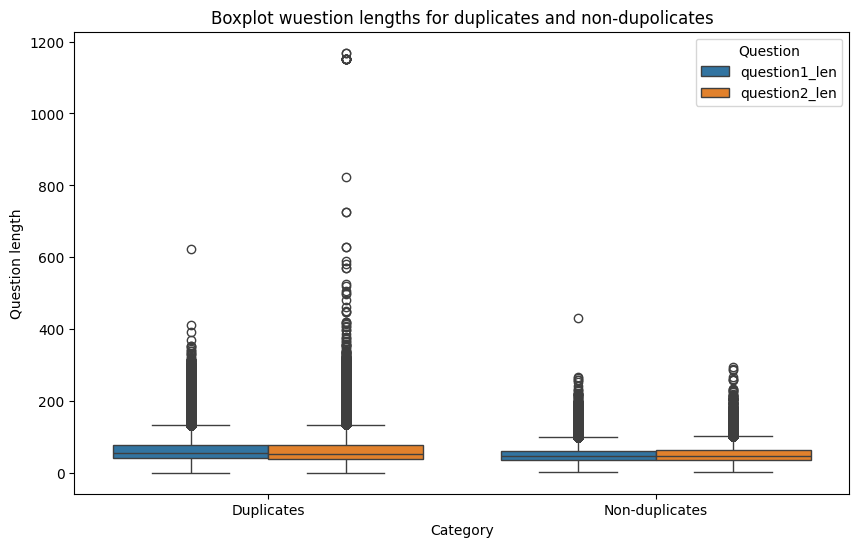

In [14]:
df_melted = df_train.melt(id_vars=['is_duplicate'], value_vars=['question1_len', 'question2_len'],
                    var_name='question', value_name='length')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='is_duplicate', y='length', hue='question')
plt.xticks([0, 1], ['Duplicates', 'Non-duplicates'])
plt.xlabel("Category")
plt.ylabel("Question length")
plt.title("Boxplot wuestion lengths for duplicates and non-dupolicates")
plt.legend(title="Question")
plt.show()

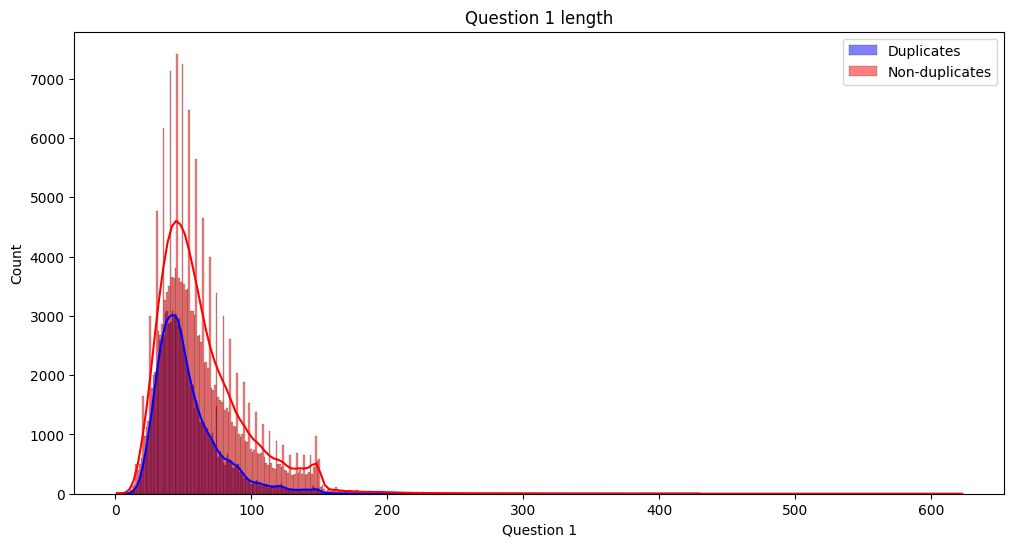

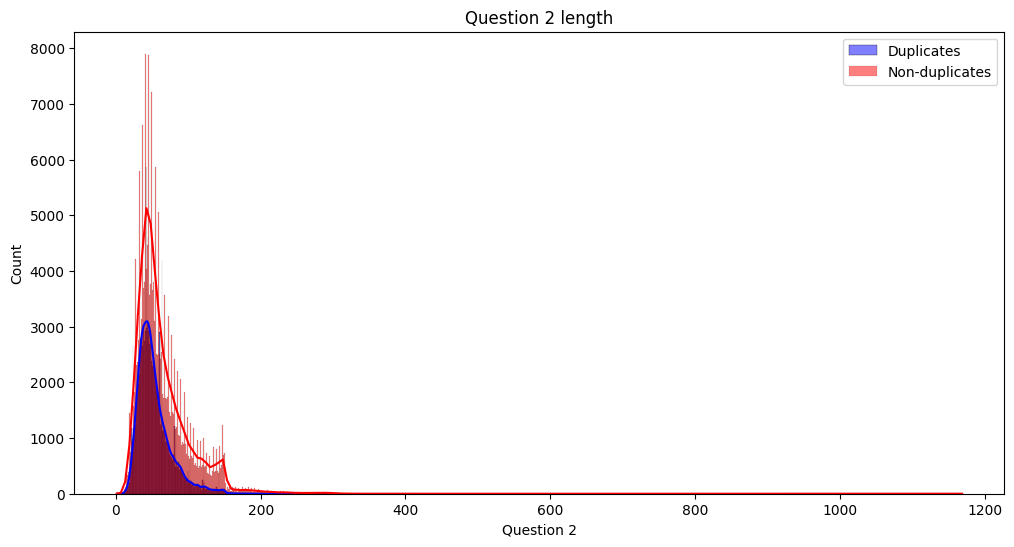

In [15]:
duplicates = df_train[df_train['is_duplicate'] == 1] 
non_duplicates = df_train[df_train['is_duplicate'] == 0] 


plt.figure(figsize=(12, 6))
sns.histplot(duplicates['question1_len'], color='blue', label='Duplicates', kde=True)
sns.histplot(non_duplicates['question1_len'], color='red', label='Non-duplicates', kde=True)
plt.title("Question 1 length")
plt.xlabel("Question 1")
plt.legend()
plt.show()

# Гістограми для довжини другого запитання
plt.figure(figsize=(12, 6))
sns.histplot(duplicates['question2_len'], color='blue', label='Duplicates', kde=True)
sns.histplot(non_duplicates['question2_len'], color='red', label='Non-duplicates', kde=True)
plt.title("Question 2 length")
plt.xlabel("Question 2")
plt.legend()
plt.show()

In [16]:
df_train.describe()

,id,qid1,qid2,is_duplicate,question1_len,question2_len
count,323429.00000,323429.000000,323429.000000,323429.000000,323429.000000,323429.000000
mean,202283.11097,217325.780641,221047.527930,0.369200,59.531761,60.123242
std,116680.10763,157709.020406,159882.915531,0.482589,29.921286,33.889595
min,0.00000,1.000000,2.000000,0.000000,1.000000,1.000000
25%,101318.00000,74614.000000,74858.000000,0.000000,39.000000,39.000000
50%,202269.00000,192394.000000,197273.000000,0.000000,52.000000,51.000000
75%,303348.00000,346598.000000,354726.000000,1.000000,72.000000,72.000000
max,404289.00000,537932.000000,537933.000000,1.000000,623.000000,1169.000000


Duplicates mostly have shorted length

Lets cut outliers for visualization purposes

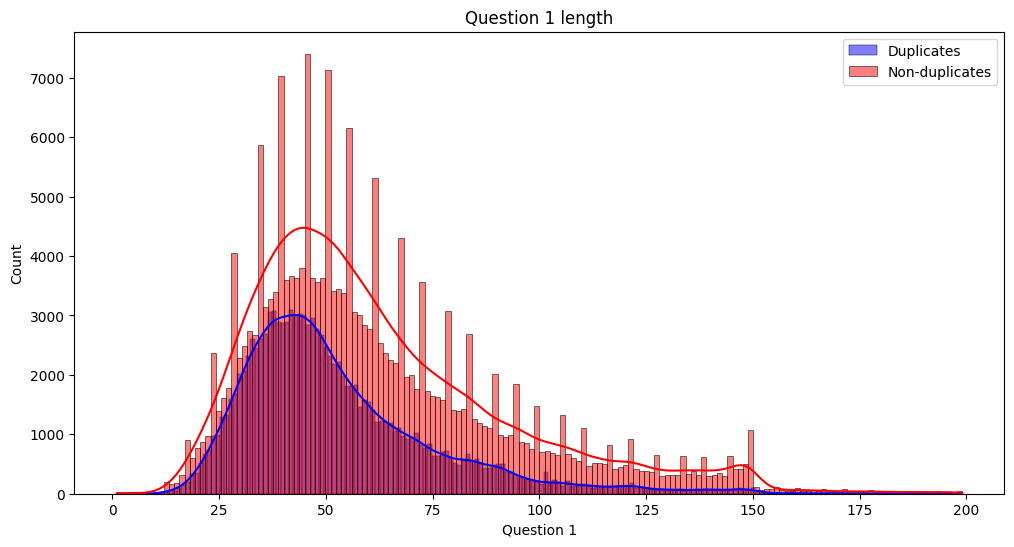

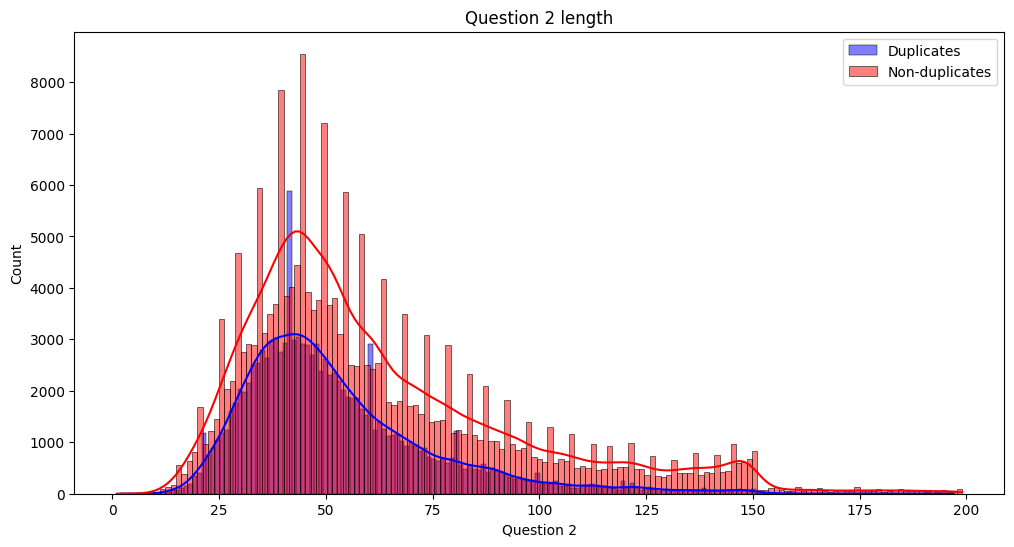

In [17]:

df_filtered = df_train[df_train['question1_len']<200]
df_filtered = df_filtered[df_train['question2_len']<200]
duplicates = df_filtered[df_filtered['is_duplicate'] == 1] 
non_duplicates = df_filtered[df_filtered['is_duplicate'] == 0] 

# Histogram for first question length
plt.figure(figsize=(12, 6))
sns.histplot(duplicates['question1_len'], color='blue', label='Duplicates', kde=True)
sns.histplot(non_duplicates['question1_len'], color='red', label='Non-duplicates', kde=True)
plt.title("Question 1 length")
plt.xlabel("Question 1")
plt.legend()
plt.show()

# Histogram for second question length
plt.figure(figsize=(12, 6))
sns.histplot(duplicates['question2_len'], color='blue', label='Duplicates', kde=True)
sns.histplot(non_duplicates['question2_len'], color='red', label='Non-duplicates', kde=True)
plt.title("Question 2 length")
plt.xlabel("Question 2")
plt.legend()
plt.show()

In [18]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in english_stopwords]
    return ' '.join(filtered_words)

def stem_tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]



In [19]:
df_train['question1_tokenized'] = df_train['question1'].apply(remove_stopwords)
df_train['question1_stemed_tokenized'] = df_train['question1_tokenized'].apply(stem_tokenize)
df_train['question2_tokenized'] = df_train['question2'].apply(remove_stopwords)
df_train['question2_stemed_tokenized'] = df_train['question2_tokenized'].apply(stem_tokenize)

/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/898982274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['question1_tokenized'] = df_train['question1'].apply(remove_stopwords)
/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/898982274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['question1_stemed_tokenized'] = df_train['question1_tokenized'].apply(stem_tokenize)
/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/898982274.py:3: Set

In [20]:
df_train

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_tokenized,question1_stemed_tokenized,question2_tokenized,question2_stemed_tokenized
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0,47,81,Iliad Odyssey Greek culture ?,"[iliad, odyssey, greek, cultur, ?]",prove pairs three independent variables also i...,"[prove, pair, three, independ, variabl, also, ..."
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0,62,55,practical management strategic management ?,"[practic, manag, strateg, manag, ?]",practical aspects strategic management ?,"[practic, aspect, strateg, manag, ?]"
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0,32,78,useful MakeUseOf Answers ?,"[use, makeuseof, answer, ?]","Q & site Yahoo answers , hate speech allowed ?","[q, &, site, yahoo, answer, ,, hate, speech, a..."
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0,51,42,best place reside India ?,"[best, place, resid, india, ?]",ia best place visit India ?,"[ia, best, place, visit, india, ?]"
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1,159,68,many people ask questions Quora easily answere...,"[mani, peopl, ask, question, quora, easili, an...",n't many people posting questions Quora check ...,"[n't, mani, peopl, post, question, quora, chec..."
...,...,...,...,...,...,...,...,...,...,...,...,...
323427,111701,182893,182894,What are the major stereotypes people have abo...,What are the major stereotypes people have abo...,0,90,89,major stereotypes people Myanmar extent true ?,"[major, stereotyp, peopl, myanmar, extent, tru...",major stereotypes people Jordan extent true ?,"[major, stereotyp, peopl, jordan, extent, true..."
323428,90934,152504,152505,What are some of the best and most creative pr...,Which is one of the worst and most insensible ...,0,84,86,best creative print advertisements ever seen ?,"[best, creativ, print, advertis, ever, seen, ?]",one worst insensible advertisements ever seen ...,"[one, worst, insens, advertis, ever, seen, tv, ?]"
323429,363857,493887,493888,Why is there a road named Aurangzeb in Delhi?,How do you justify naming a road after Aurangzeb?,0,45,49,road named Aurangzeb Delhi ?,"[road, name, aurangzeb, delhi, ?]",justify naming road Aurangzeb ?,"[justifi, name, road, aurangzeb, ?]"
323430,29409,54414,54415,What are the tips given to a teacher to satisf...,Can a high school teacher legally force studen...,0,76,90,tips given teacher satisfy students class ?,"[tip, given, teacher, satisfi, student, class, ?]",high school teacher legally force students sta...,"[high, school, teacher, legal, forc, student, ..."


Here we see that for example questions with id=196656 have almost same words in both questions but they are not duplicates, so words order has real impact

In [21]:
df_train['common_words_count'] = df_train.apply(lambda row: len(set(row['question1_stemed_tokenized']).intersection(row['question2_stemed_tokenized'])), axis=1)


/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/287619809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['common_words_count'] = df_train.apply(lambda row: len(set(row['question1_stemed_tokenized']).intersection(row['question2_stemed_tokenized'])), axis=1)


In [22]:
df_train

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_tokenized,question1_stemed_tokenized,question2_tokenized,question2_stemed_tokenized,common_words_count
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0,47,81,Iliad Odyssey Greek culture ?,"[iliad, odyssey, greek, cultur, ?]",prove pairs three independent variables also i...,"[prove, pair, three, independ, variabl, also, ...",1
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0,62,55,practical management strategic management ?,"[practic, manag, strateg, manag, ?]",practical aspects strategic management ?,"[practic, aspect, strateg, manag, ?]",4
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0,32,78,useful MakeUseOf Answers ?,"[use, makeuseof, answer, ?]","Q & site Yahoo answers , hate speech allowed ?","[q, &, site, yahoo, answer, ,, hate, speech, a...",2
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0,51,42,best place reside India ?,"[best, place, resid, india, ?]",ia best place visit India ?,"[ia, best, place, visit, india, ?]",4
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1,159,68,many people ask questions Quora easily answere...,"[mani, peopl, ask, question, quora, easili, an...",n't many people posting questions Quora check ...,"[n't, mani, peopl, post, question, quora, chec...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323427,111701,182893,182894,What are the major stereotypes people have abo...,What are the major stereotypes people have abo...,0,90,89,major stereotypes people Myanmar extent true ?,"[major, stereotyp, peopl, myanmar, extent, tru...",major stereotypes people Jordan extent true ?,"[major, stereotyp, peopl, jordan, extent, true...",6
323428,90934,152504,152505,What are some of the best and most creative pr...,Which is one of the worst and most insensible ...,0,84,86,best creative print advertisements ever seen ?,"[best, creativ, print, advertis, ever, seen, ?]",one worst insensible advertisements ever seen ...,"[one, worst, insens, advertis, ever, seen, tv, ?]",4
323429,363857,493887,493888,Why is there a road named Aurangzeb in Delhi?,How do you justify naming a road after Aurangzeb?,0,45,49,road named Aurangzeb Delhi ?,"[road, name, aurangzeb, delhi, ?]",justify naming road Aurangzeb ?,"[justifi, name, road, aurangzeb, ?]",4
323430,29409,54414,54415,What are the tips given to a teacher to satisf...,Can a high school teacher legally force studen...,0,76,90,tips given teacher satisfy students class ?,"[tip, given, teacher, satisfi, student, class, ?]",high school teacher legally force students sta...,"[high, school, teacher, legal, forc, student, ...",4


In [23]:
df_train['q1_words_count'] = df_train.apply(lambda row: len(row['question1_stemed_tokenized']), axis=1)
df_train['q2_words_count'] = df_train.apply(lambda row: len(row['question2_stemed_tokenized']), axis=1)

/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/3314574641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['q1_words_count'] = df_train.apply(lambda row: len(row['question1_stemed_tokenized']), axis=1)
/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/3314574641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['q2_words_count'] = df_train.apply(lambda row: len(row['question2_stemed_tokenized']), axis=1)


In [24]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_tokenized,question1_stemed_tokenized,question2_tokenized,question2_stemed_tokenized,common_words_count,q1_words_count,q2_words_count
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0,47,81,Iliad Odyssey Greek culture ?,"[iliad, odyssey, greek, cultur, ?]",prove pairs three independent variables also i...,"[prove, pair, three, independ, variabl, also, ...",1,5,8
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0,62,55,practical management strategic management ?,"[practic, manag, strateg, manag, ?]",practical aspects strategic management ?,"[practic, aspect, strateg, manag, ?]",4,5,5
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0,32,78,useful MakeUseOf Answers ?,"[use, makeuseof, answer, ?]","Q & site Yahoo answers , hate speech allowed ?","[q, &, site, yahoo, answer, ,, hate, speech, a...",2,4,10
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0,51,42,best place reside India ?,"[best, place, resid, india, ?]",ia best place visit India ?,"[ia, best, place, visit, india, ?]",4,5,6
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1,159,68,many people ask questions Quora easily answere...,"[mani, peopl, ask, question, quora, easili, an...",n't many people posting questions Quora check ...,"[n't, mani, peopl, post, question, quora, chec...",6,16,10


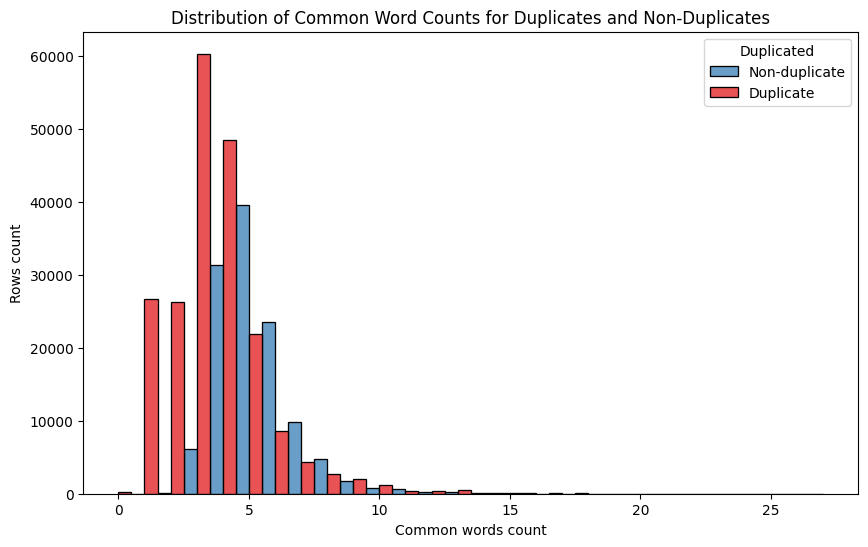

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='common_words_count', hue='is_duplicate', bins=range(df_train['common_words_count'].max() + 2), 
             multiple='dodge', palette='Set1')
plt.xlabel('Common words count')
plt.ylabel('Rows count')
plt.title('Distribution of Common Word Counts for Duplicates and Non-Duplicates')
plt.legend(title='Duplicated', labels=['Non-duplicate', 'Duplicate'])
plt.show()

Here we see that if common words is less than 5, commonly questions are more likely duplicates, and questions are more likely non-duplicates if common words are greater than 5

So, this shows us, that Bag of Words is not really applicable in this task

Let's use TF-IDF 

In [26]:
df_train['question1_stemed_tokenized_str'] = df_train['question1_stemed_tokenized'].apply(lambda x: ' '.join(x))
df_train['question2_stemed_tokenized_str'] = df_train['question2_stemed_tokenized'].apply(lambda x: ' '.join(x))

/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/1217949569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['question1_stemed_tokenized_str'] = df_train['question1_stemed_tokenized'].apply(lambda x: ' '.join(x))
/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/1217949569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['question2_stemed_tokenized_str'] = df_train['question2_stemed_tokenized'].apply(lambda x: ' '.join(x))


In [27]:
df_train['combined'] = df_train['question1_stemed_tokenized_str']+' '+df_train['question2_stemed_tokenized_str']

/var/folders/2z/b500qw6s6cx6j167ynb3767c0000gn/T/ipykernel_11566/2897027628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['combined'] = df_train['question1_stemed_tokenized_str']+' '+df_train['question2_stemed_tokenized_str']


In [28]:
tf_idf = TfidfVectorizer()
tf_idf_matrix = tf_idf.fit_transform(df_train['combined'])

In [29]:
tf_idf.get_feature_names_out()

array(['00', '000', '0000', ..., '하지만', '한글', 'ﬁnd'], dtype=object)

In [30]:
tf_idf_matrix.shape

(323429, 61797)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, df_train['is_duplicate'], test_size=0.25, random_state=42)

In [32]:
logisticModel = LogisticRegression(solver='liblinear', max_iter=1000, n_jobs=100)
logisticModel.fit(X_train, y_train)
y_train_pred = logisticModel.predict(X_train)
y_train_proba = logisticModel.predict_proba(X_train)

In [33]:
y_train_proba[:, 1]

array([0.33030198, 0.0834872 , 0.46946638, ..., 0.21579145, 0.06298957,
       0.75268263])

In [34]:
log_loss_val = log_loss(y_train, y_train_proba[:, 1])
roc_auc_val = roc_auc_score(y_train, y_train_pred)
print('Log loss value={}, roc_auc_score value={}'.format(log_loss_val, roc_auc_val))

Log loss value=0.48505241510279096, roc_auc_score value=0.7235485129309387


In [ ]:
y_test_pred = logisticModel.predict(X_test)
y_test_proba = logisticModel.predict_proba(X_test)
log_loss_val = log_loss(y_test, y_test_proba[:, 1])
roc_auc_val = roc_auc_score(y_test, y_test_pred)
print('Log loss VAL value={}, roc_auc_score value={}'.format(log_loss_val, roc_auc_val))

Log loss TEST value=0.5142958426844461, roc_auc_score value=0.70308174334583


Results are not so good with simple Logistic Resgression model